In [21]:
import glob
import re
import sqlite3
import time
import traceback
from pathlib import Path

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.model_selection import train_test_split

In [22]:
# download hart16 files from: https://data.galaxyzoo.org/#section-12
# download images and mapping from: https://zenodo.org/record/3565489#.Y3vFKS-l0eY
FILENAME_MAPPINGS = "data/gz2_filename_mapping.csv"
HART16 = "data/gz2_hart16.csv"

ORIGINAL_IMAGES_DIR = "data/images/"
PROCESSED_IMAGES_DIR = "data/images_processed/"
RANDOM_STATE = 32
TRAIN_IMAGES_DIR = "data/train_images/"
TEST_IMAGES_DIR = "data/test_images/"

## Process CSV Files

In [23]:
# dtypes for Hart columns
# note, objid column must use Int64, int is too small
dtype_hart = {
    "dr7objid": "Int64",
    "ra": float,
    "dec": float,
    "rastring": str,
    "decstring": str,
    "sample": str,
    "gz2_class": str,
    "total_classifications": int,
    "total_votes": int,
    "t01_smooth_or_features_a01_smooth_count": int,
    "t01_smooth_or_features_a01_smooth_weight": float,
    "t01_smooth_or_features_a01_smooth_fraction": float,
    "t01_smooth_or_features_a01_smooth_weighted_fraction": float,
    "t01_smooth_or_features_a01_smooth_debiased": float,
    "t01_smooth_or_features_a01_smooth_flag": int,
    "t01_smooth_or_features_a02_features_or_disk_count": int,
    "t01_smooth_or_features_a02_features_or_disk_weight": float,
    "t01_smooth_or_features_a02_features_or_disk_fraction": float,
    "t01_smooth_or_features_a02_features_or_disk_weighted_fraction": float,
    "t01_smooth_or_features_a02_features_or_disk_debiased": float,
    "t01_smooth_or_features_a02_features_or_disk_flag": int,
    "t01_smooth_or_features_a03_star_or_artifact_count": int,
    "t01_smooth_or_features_a03_star_or_artifact_weight": float,
    "t01_smooth_or_features_a03_star_or_artifact_fraction": float,
    "t01_smooth_or_features_a03_star_or_artifact_weighted_fraction": float,
    "t01_smooth_or_features_a03_star_or_artifact_debiased": float,
    "t01_smooth_or_features_a03_star_or_artifact_flag": int,
    "t02_edgeon_a04_yes_count": int,
    "t02_edgeon_a04_yes_weight": float,
    "t02_edgeon_a04_yes_fraction": float,
    "t02_edgeon_a04_yes_weighted_fraction": float,
    "t02_edgeon_a04_yes_debiased": float,
    "t02_edgeon_a04_yes_flag": int,
    "t02_edgeon_a05_no_count": int,
    "t02_edgeon_a05_no_weight": float,
    "t02_edgeon_a05_no_fraction": float,
    "t02_edgeon_a05_no_weighted_fraction": float,
    "t02_edgeon_a05_no_debiased": float,
    "t02_edgeon_a05_no_flag": int,
    "t03_bar_a06_bar_count": int,
    "t03_bar_a06_bar_weight": float,
    "t03_bar_a06_bar_fraction": float,
    "t03_bar_a06_bar_weighted_fraction": float,
    "t03_bar_a06_bar_debiased": float,
    "t03_bar_a06_bar_flag": int,
    "t03_bar_a07_no_bar_count": int,
    "t03_bar_a07_no_bar_weight": float,
    "t03_bar_a07_no_bar_fraction": float,
    "t03_bar_a07_no_bar_weighted_fraction": float,
    "t03_bar_a07_no_bar_debiased": float,
    "t03_bar_a07_no_bar_flag": int,
    "t04_spiral_a08_spiral_count": int,
    "t04_spiral_a08_spiral_weight": float,
    "t04_spiral_a08_spiral_fraction": float,
    "t04_spiral_a08_spiral_weighted_fraction": float,
    "t04_spiral_a08_spiral_debiased": float,
    "t04_spiral_a08_spiral_flag": int,
    "t04_spiral_a09_no_spiral_count": int,
    "t04_spiral_a09_no_spiral_weight": float,
    "t04_spiral_a09_no_spiral_fraction": float,
    "t04_spiral_a09_no_spiral_weighted_fraction": float,
    "t04_spiral_a09_no_spiral_debiased": float,
    "t04_spiral_a09_no_spiral_flag": int,
    "t05_bulge_prominence_a10_no_bulge_count": int,
    "t05_bulge_prominence_a10_no_bulge_weight": float,
    "t05_bulge_prominence_a10_no_bulge_fraction": float,
    "t05_bulge_prominence_a10_no_bulge_weighted_fraction": float,
    "t05_bulge_prominence_a10_no_bulge_debiased": float,
    "t05_bulge_prominence_a10_no_bulge_flag": int,
    "t05_bulge_prominence_a11_just_noticeable_count": int,
    "t05_bulge_prominence_a11_just_noticeable_weight": float,
    "t05_bulge_prominence_a11_just_noticeable_fraction": float,
    "t05_bulge_prominence_a11_just_noticeable_weighted_fraction": float,
    "t05_bulge_prominence_a11_just_noticeable_debiased": float,
    "t05_bulge_prominence_a11_just_noticeable_flag": int,
    "t05_bulge_prominence_a12_obvious_count": int,
    "t05_bulge_prominence_a12_obvious_weight": float,
    "t05_bulge_prominence_a12_obvious_fraction": float,
    "t05_bulge_prominence_a12_obvious_weighted_fraction": float,
    "t05_bulge_prominence_a12_obvious_debiased": float,
    "t05_bulge_prominence_a12_obvious_flag": int,
    "t05_bulge_prominence_a13_dominant_count": int,
    "t05_bulge_prominence_a13_dominant_weight": float,
    "t05_bulge_prominence_a13_dominant_fraction": float,
    "t05_bulge_prominence_a13_dominant_weighted_fraction": float,
    "t05_bulge_prominence_a13_dominant_debiased": float,
    "t05_bulge_prominence_a13_dominant_flag": int,
    "t06_odd_a14_yes_count": int,
    "t06_odd_a14_yes_weight": float,
    "t06_odd_a14_yes_fraction": float,
    "t06_odd_a14_yes_weighted_fraction": float,
    "t06_odd_a14_yes_debiased": float,
    "t06_odd_a14_yes_flag": int,
    "t06_odd_a15_no_count": int,
    "t06_odd_a15_no_weight": float,
    "t06_odd_a15_no_fraction": float,
    "t06_odd_a15_no_weighted_fraction": float,
    "t06_odd_a15_no_debiased": float,
    "t06_odd_a15_no_flag": int,
    "t07_rounded_a16_completely_round_count": int,
    "t07_rounded_a16_completely_round_weight": float,
    "t07_rounded_a16_completely_round_fraction": float,
    "t07_rounded_a16_completely_round_weighted_fraction": float,
    "t07_rounded_a16_completely_round_debiased": float,
    "t07_rounded_a16_completely_round_flag": int,
    "t07_rounded_a17_in_between_count": int,
    "t07_rounded_a17_in_between_weight": float,
    "t07_rounded_a17_in_between_fraction": float,
    "t07_rounded_a17_in_between_weighted_fraction": float,
    "t07_rounded_a17_in_between_debiased": float,
    "t07_rounded_a17_in_between_flag": int,
    "t07_rounded_a18_cigar_shaped_count": int,
    "t07_rounded_a18_cigar_shaped_weight": float,
    "t07_rounded_a18_cigar_shaped_fraction": float,
    "t07_rounded_a18_cigar_shaped_weighted_fraction": float,
    "t07_rounded_a18_cigar_shaped_debiased": float,
    "t07_rounded_a18_cigar_shaped_flag": int,
    "t08_odd_feature_a19_ring_count": int,
    "t08_odd_feature_a19_ring_weight": float,
    "t08_odd_feature_a19_ring_fraction": float,
    "t08_odd_feature_a19_ring_weighted_fraction": float,
    "t08_odd_feature_a19_ring_debiased": float,
    "t08_odd_feature_a19_ring_flag": int,
    "t08_odd_feature_a20_lens_or_arc_count": int,
    "t08_odd_feature_a20_lens_or_arc_weight": float,
    "t08_odd_feature_a20_lens_or_arc_fraction": float,
    "t08_odd_feature_a20_lens_or_arc_weighted_fraction": float,
    "t08_odd_feature_a20_lens_or_arc_debiased": float,
    "t08_odd_feature_a20_lens_or_arc_flag": int,
    "t08_odd_feature_a21_disturbed_count": int,
    "t08_odd_feature_a21_disturbed_weight": float,
    "t08_odd_feature_a21_disturbed_fraction": float,
    "t08_odd_feature_a21_disturbed_weighted_fraction": float,
    "t08_odd_feature_a21_disturbed_debiased": float,
    "t08_odd_feature_a21_disturbed_flag": int,
    "t08_odd_feature_a22_irregular_count": int,
    "t08_odd_feature_a22_irregular_weight": float,
    "t08_odd_feature_a22_irregular_fraction": float,
    "t08_odd_feature_a22_irregular_weighted_fraction": float,
    "t08_odd_feature_a22_irregular_debiased": float,
    "t08_odd_feature_a22_irregular_flag": int,
    "t08_odd_feature_a23_other_count": int,
    "t08_odd_feature_a23_other_weight": float,
    "t08_odd_feature_a23_other_fraction": float,
    "t08_odd_feature_a23_other_weighted_fraction": float,
    "t08_odd_feature_a23_other_debiased": float,
    "t08_odd_feature_a23_other_flag": int,
    "t08_odd_feature_a24_merger_count": int,
    "t08_odd_feature_a24_merger_weight": float,
    "t08_odd_feature_a24_merger_fraction": float,
    "t08_odd_feature_a24_merger_weighted_fraction": float,
    "t08_odd_feature_a24_merger_debiased": float,
    "t08_odd_feature_a24_merger_flag": int,
    "t08_odd_feature_a38_dust_lane_count": int,
    "t08_odd_feature_a38_dust_lane_weight": float,
    "t08_odd_feature_a38_dust_lane_fraction": float,
    "t08_odd_feature_a38_dust_lane_weighted_fraction": float,
    "t08_odd_feature_a38_dust_lane_debiased": float,
    "t08_odd_feature_a38_dust_lane_flag": int,
    "t09_bulge_shape_a25_rounded_count": int,
    "t09_bulge_shape_a25_rounded_weight": float,
    "t09_bulge_shape_a25_rounded_fraction": float,
    "t09_bulge_shape_a25_rounded_weighted_fraction": float,
    "t09_bulge_shape_a25_rounded_debiased": float,
    "t09_bulge_shape_a25_rounded_flag": int,
    "t09_bulge_shape_a26_boxy_count": int,
    "t09_bulge_shape_a26_boxy_weight": float,
    "t09_bulge_shape_a26_boxy_fraction": float,
    "t09_bulge_shape_a26_boxy_weighted_fraction": float,
    "t09_bulge_shape_a26_boxy_debiased": float,
    "t09_bulge_shape_a26_boxy_flag": int,
    "t09_bulge_shape_a27_no_bulge_count": int,
    "t09_bulge_shape_a27_no_bulge_weight": float,
    "t09_bulge_shape_a27_no_bulge_fraction": float,
    "t09_bulge_shape_a27_no_bulge_weighted_fraction": float,
    "t09_bulge_shape_a27_no_bulge_debiased": float,
    "t09_bulge_shape_a27_no_bulge_flag": int,
    "t10_arms_winding_a28_tight_count": int,
    "t10_arms_winding_a28_tight_weight": float,
    "t10_arms_winding_a28_tight_fraction": float,
    "t10_arms_winding_a28_tight_weighted_fraction": float,
    "t10_arms_winding_a28_tight_debiased": float,
    "t10_arms_winding_a28_tight_flag": int,
    "t10_arms_winding_a29_medium_count": int,
    "t10_arms_winding_a29_medium_weight": float,
    "t10_arms_winding_a29_medium_fraction": float,
    "t10_arms_winding_a29_medium_weighted_fraction": float,
    "t10_arms_winding_a29_medium_debiased": float,
    "t10_arms_winding_a29_medium_flag": int,
    "t10_arms_winding_a30_loose_count": int,
    "t10_arms_winding_a30_loose_weight": float,
    "t10_arms_winding_a30_loose_fraction": float,
    "t10_arms_winding_a30_loose_weighted_fraction": float,
    "t10_arms_winding_a30_loose_debiased": float,
    "t10_arms_winding_a30_loose_flag": int,
    "t11_arms_number_a31_1_count": int,
    "t11_arms_number_a31_1_weight": float,
    "t11_arms_number_a31_1_fraction": float,
    "t11_arms_number_a31_1_weighted_fraction": float,
    "t11_arms_number_a31_1_debiased": float,
    "t11_arms_number_a31_1_flag": int,
    "t11_arms_number_a32_2_count": int,
    "t11_arms_number_a32_2_weight": float,
    "t11_arms_number_a32_2_fraction": float,
    "t11_arms_number_a32_2_weighted_fraction": float,
    "t11_arms_number_a32_2_debiased": float,
    "t11_arms_number_a32_2_flag": int,
    "t11_arms_number_a33_3_count": int,
    "t11_arms_number_a33_3_weight": float,
    "t11_arms_number_a33_3_fraction": float,
    "t11_arms_number_a33_3_weighted_fraction": float,
    "t11_arms_number_a33_3_debiased": float,
    "t11_arms_number_a33_3_flag": int,
    "t11_arms_number_a34_4_count": int,
    "t11_arms_number_a34_4_weight": float,
    "t11_arms_number_a34_4_fraction": float,
    "t11_arms_number_a34_4_weighted_fraction": float,
    "t11_arms_number_a34_4_debiased": float,
    "t11_arms_number_a34_4_flag": int,
    "t11_arms_number_a36_more_than_4_count": int,
    "t11_arms_number_a36_more_than_4_weight": float,
    "t11_arms_number_a36_more_than_4_fraction": float,
    "t11_arms_number_a36_more_than_4_weighted_fraction": float,
    "t11_arms_number_a36_more_than_4_debiased": float,
    "t11_arms_number_a36_more_than_4_flag": int,
    "t11_arms_number_a37_cant_tell_count": int,
    "t11_arms_number_a37_cant_tell_weight": float,
    "t11_arms_number_a37_cant_tell_fraction": float,
    "t11_arms_number_a37_cant_tell_weighted_fraction": float,
    "t11_arms_number_a37_cant_tell_debiased": float,
    "t11_arms_number_a37_cant_tell_flag": int
}

# columns to keep from Hart
hart_keep = ["dr7objid", "ra", "dec", "gz2_class"]
# Keep only debiased columns and the above 4 columns
for col_name in dtype_hart.keys():
    if col_name.endswith("_debiased"):
        hart_keep.append(col_name)

### Load the CSV Files

In [24]:
df_mappings = pd.read_csv(FILENAME_MAPPINGS,
                          header=0,
                          dtype={"objid": "Int64",
                                 "sample": str,
                                 "asset_id": int})
df_mappings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355990 entries, 0 to 355989
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   objid     355990 non-null  Int64 
 1   sample    355990 non-null  object
 2   asset_id  355990 non-null  int32 
dtypes: Int64(1), int32(1), object(1)
memory usage: 7.1+ MB


In [25]:
df_hart16 = pd.read_csv(HART16,
                        header=0,
                        dtype=dtype_hart,
                        usecols=hart_keep)
df_hart16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239695 entries, 0 to 239694
Data columns (total 41 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   dr7objid                                              239695 non-null  Int64  
 1   ra                                                    239695 non-null  float64
 2   dec                                                   239695 non-null  float64
 3   gz2_class                                             239695 non-null  object 
 4   t01_smooth_or_features_a01_smooth_debiased            239695 non-null  float64
 5   t01_smooth_or_features_a02_features_or_disk_debiased  239695 non-null  float64
 6   t01_smooth_or_features_a03_star_or_artifact_debiased  239695 non-null  float64
 7   t02_edgeon_a04_yes_debiased                           239695 non-null  float64
 8   t02_edgeon_a05_no_debiased                  

### Check for duplicates

In [26]:
print("Duplicates in objID to image mapping file")
df_mappings.duplicated("objid").value_counts()

Duplicates in objID to image mapping file


False    325651
True      30339
dtype: int64

In [27]:
print("Duplicates in Hart16 data file")
df_hart16.duplicated("dr7objid").value_counts()

Duplicates in Hart16 data file


False    239695
dtype: int64

In [28]:
_dupe_df_mappings = df_mappings[df_mappings.duplicated("objid", keep=False)]\
                                .sort_values("asset_id")\
                                .reset_index(drop=True)
_dupe_id_first = _dupe_df_mappings['asset_id'].iloc[0]
_dupe_id_last = _dupe_df_mappings['asset_id'].iloc[-1]
print(f"asset_id in objid duplicates: First: {_dupe_id_first}, Last: {_dupe_id_last}, diff:{_dupe_id_last-_dupe_id_first}, count:{_dupe_df_mappings.shape[0]}")
print("None of these are in the provided images")

asset_id in objid duplicates: First: 295306, Last: 355990, diff:60684, count:60678
None of these are in the provided images


In [29]:
# drop rows with asset_id not in image list to remove duplicates
df_mappings_clean = df_mappings[df_mappings["asset_id"] < 295306]
print("Are there duplicates in mappings now?")
df_mappings_clean.duplicated("objid").value_counts()

Are there duplicates in mappings now?


False    295305
dtype: int64

### Merge the two DataFames, remove NaN rows

In [34]:
df_joined = pd.merge(df_mappings_clean, df_hart16,
                     left_on="objid",
                     right_on="dr7objid",
                     how="inner",
                     validate="one_to_one",
                     sort=False)
print(df_joined.shape)

# Check for NaN and remove those rows
print("Rows with NaN:", df_joined.isnull().any(axis=1).sum())
print("Dropping rows")
df_joined.dropna(inplace=True)
print(df_joined.shape)

df_joined.head()

(239695, 44)
Rows with NaN: 306
Dropping rows
(239389, 44)


,objid,sample,asset_id,dr7objid,ra,dec,gz2_class,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a03_star_or_artifact_debiased,...,t09_bulge_shape_a27_no_bulge_debiased,t10_arms_winding_a28_tight_debiased,t10_arms_winding_a29_medium_debiased,t10_arms_winding_a30_loose_debiased,t11_arms_number_a31_1_debiased,t11_arms_number_a32_2_debiased,t11_arms_number_a33_3_debiased,t11_arms_number_a34_4_debiased,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a37_cant_tell_debiased
0,587722981741363294,original,3,587722981741363294,182.925262,-1.092357,Sb,0.459,0.681,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,587722981741363323,original,4,587722981741363323,182.970108,-1.219537,Sc?l,0.216,0.736,0.000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,587722981741559888,original,5,587722981741559888,183.438095,-1.238414,Er,0.773,0.029,0.114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,587722981741625481,original,6,587722981741625481,183.473999,-1.231429,Sc1t,0.152,0.639,0.009,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,587722981741625484,original,7,587722981741625484,183.477783,-1.084604,Sb,0.182,0.720,0.032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check Images
See if images in folder match up to `asset_id` in the DataFrame

In [35]:
# get list of all images in the image folder
image_files = glob.glob(ORIGINAL_IMAGES_DIR + "*.jpg")
print("Image count:", len(image_files))

# Get image names, these should match up to `asset_id`
regex = re.compile(r"images\\(\d*)\.jpg")
image_names = [int(re.search(regex, img).group(1)) for img in image_files]
image_names.sort()
print("First 10 image names:")
image_names[0:10]

Image count: 243434
First 10 image names:


[3, 4, 5, 6, 7, 8, 9, 11, 12, 13]

In [36]:
table_asset = df_joined["asset_id"].to_list()
# create list of images that are not in images
not_in_images = list(set(table_asset) - set(image_names))
print("Not in images, In table (drop these rows)", len(not_in_images))

# create list of data that is not in the table
not_in_table = list(set(image_names) - set(table_asset))
print("Not in table, In images (do not process these images)", len(not_in_table))

Not in images, In table (drop these rows) 122
Not in table, In images (do not process these images) 4167


Remove rows that do not have images

In [37]:
# Keep rows that are not in (`~`) `not_in_images` list
df_joined_clean = df_joined[~df_joined["asset_id"].isin(not_in_images)]
df_joined_clean.shape

(239267, 44)

Create a new column that reduces the number of `gz2_class` options. When we separate our data into testing and training, we want to stratify the data, but we can only use 1 column. The `gz2_class` column is perfect for this but there are many values that only have 1 or 2 matching rows.

We will use the cutoff at `12`

In [38]:
gz2class_vc = df_hart16["gz2_class"].value_counts()
print("Total classes:", gz2class_vc.shape[0])

very_rare_classes = gz2class_vc.loc[gz2class_vc < 12]
very_rare_classes

Total classes: 818


Sc+m(o)     11
SBb3m(m)    11
SBc4m(r)    11
SBc?l(m)    11
SBc3l(i)    11
            ..
SBc4t(u)     1
SBc+l(m)     1
Sa?l(i)      1
SBd+m(i)     1
Sd3m(o)      1
Name: gz2_class, Length: 421, dtype: int64

In [39]:
regex_spiral_arm_and_winding = re.compile(r"([1234+?][tml])")

def convert_rare_class(original_class_name: str) -> str:
    """Removes the spiral arm count and spiral winding parts of a
    string if there is a rare feature: (x)

    Use this to reduce the amount of gz2_class strings for better stratifying

    :param original_class_name: GZ2 Class name
    :return: Class name without spiral parts
    """
    # If there is no rare feature, don't change the class
    if not original_class_name.endswith(")"):
        return original_class_name
    
    # Elliptical galaxies probably are not here anyways
    if original_class_name.startswith("E"):
        return original_class_name
    
    # Get the (x) feature
    rare_feature = original_class_name[-3:]
    
    # Check for spiral arm count and winding
    re_match = re.search(regex_spiral_arm_and_winding, original_class_name)
    if re_match is not None:
        # Get the shape, bar, bulge prominence & combine with rare feature
        shape_bar_bulge = original_class_name[:-5]
        return shape_bar_bulge + rare_feature
    else:
        # Nothing to remove, return original
        return original_class_name

# Reduce number of rare classes
very_rare_class_mapping = {}
for orig_class_name in very_rare_classes.index.to_list():
    new_name = convert_rare_class(orig_class_name)
    very_rare_class_mapping[orig_class_name] = new_name

# count of new classes
print("Original very rare classes count:", len(very_rare_classes.index.to_list()))
print("Reduced very rare classes count:", len(set(very_rare_class_mapping.values())))

Original very rare classes count: 421
Reduced very rare classes count: 106


In [40]:
# create a new column from `gz2_class` and replace the rare classes with our new classes
df_joined_clean["class_reduced"] = df_joined_clean["gz2_class"].replace(very_rare_class_mapping)
print("Total reduced classes:", df_joined_clean["class_reduced"].value_counts().shape[0])
print("")

Total reduced classes: 468



C:\Users\Zachary\AppData\Local\Temp\ipykernel_15324\2600318297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined_clean["class_reduced"] = df_joined_clean["gz2_class"].replace(very_rare_class_mapping)


There are still some classes that are `<= 3` so we will just put them into a single "SuperRare" group

In [41]:
# Number of Super rare classes (3 or less members)
vc = df_joined_clean["class_reduced"].value_counts()
vc_super_rare = vc[vc <= 3]
print("Super Rare classes")
print(f"# of classes: {len(vc_super_rare)}, Total lines {vc_super_rare.sum()}")

# Reduce number of super rare classes
super_rare_class_mapping = {}
for orig_class_name in vc_super_rare.index.to_list():
    super_rare_class_mapping[orig_class_name] = "SuperRare"

df_joined_clean["class_reduced"] = df_joined_clean["class_reduced"].replace(super_rare_class_mapping)
print("Final reduced classes:", df_joined_clean["class_reduced"].value_counts().shape[0])
print("")

Super Rare classes
# of classes: 36, Total lines 61
Final reduced classes: 433



C:\Users\Zachary\AppData\Local\Temp\ipykernel_15324\3953704224.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined_clean["class_reduced"] = df_joined_clean["class_reduced"].replace(super_rare_class_mapping)


In [42]:
# The final DataFrame
print(df_joined_clean.shape)
df_joined_clean.head()

(239267, 45)


,objid,sample,asset_id,dr7objid,ra,dec,gz2_class,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a03_star_or_artifact_debiased,...,t10_arms_winding_a28_tight_debiased,t10_arms_winding_a29_medium_debiased,t10_arms_winding_a30_loose_debiased,t11_arms_number_a31_1_debiased,t11_arms_number_a32_2_debiased,t11_arms_number_a33_3_debiased,t11_arms_number_a34_4_debiased,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a37_cant_tell_debiased,class_reduced
0,587722981741363294,original,3,587722981741363294,182.925262,-1.092357,Sb,0.459,0.681,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sb
1,587722981741363323,original,4,587722981741363323,182.970108,-1.219537,Sc?l,0.216,0.736,0.000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Sc?l
2,587722981741559888,original,5,587722981741559888,183.438095,-1.238414,Er,0.773,0.029,0.114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Er
3,587722981741625481,original,6,587722981741625481,183.473999,-1.231429,Sc1t,0.152,0.639,0.009,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sc1t
4,587722981741625484,original,7,587722981741625484,183.477783,-1.084604,Sb,0.182,0.720,0.032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sb


In [43]:
# Save final DataFrame to SQLite
connection = sqlite3.connect("data/galaxy_data.sqlite")
df_joined_clean.to_sql("galaxy_data", connection, index=False, if_exists="replace")
connection.close()

---
## Explore Distribution of Features

t01_smooth_or_features_a01_smooth_debiased               97268
t01_smooth_or_features_a02_features_or_disk_debiased    141628
t01_smooth_or_features_a03_star_or_artifact_debiased         6
t02_edgeon_a04_yes_debiased                              28939
t02_edgeon_a05_no_debiased                              210726
t03_bar_a06_bar_debiased                                 59493
t03_bar_a07_no_bar_debiased                             160819
t04_spiral_a08_spiral_debiased                          123707
t04_spiral_a09_no_spiral_debiased                       102868
t05_bulge_prominence_a10_no_bulge_debiased                9316
t05_bulge_prominence_a11_just_noticeable_debiased        99107
t05_bulge_prominence_a12_obvious_debiased                89585
t05_bulge_prominence_a13_dominant_debiased                4487
t06_odd_a14_yes_debiased                                 34961
t06_odd_a15_no_debiased                                 203606
t07_rounded_a16_completely_round_debiased              

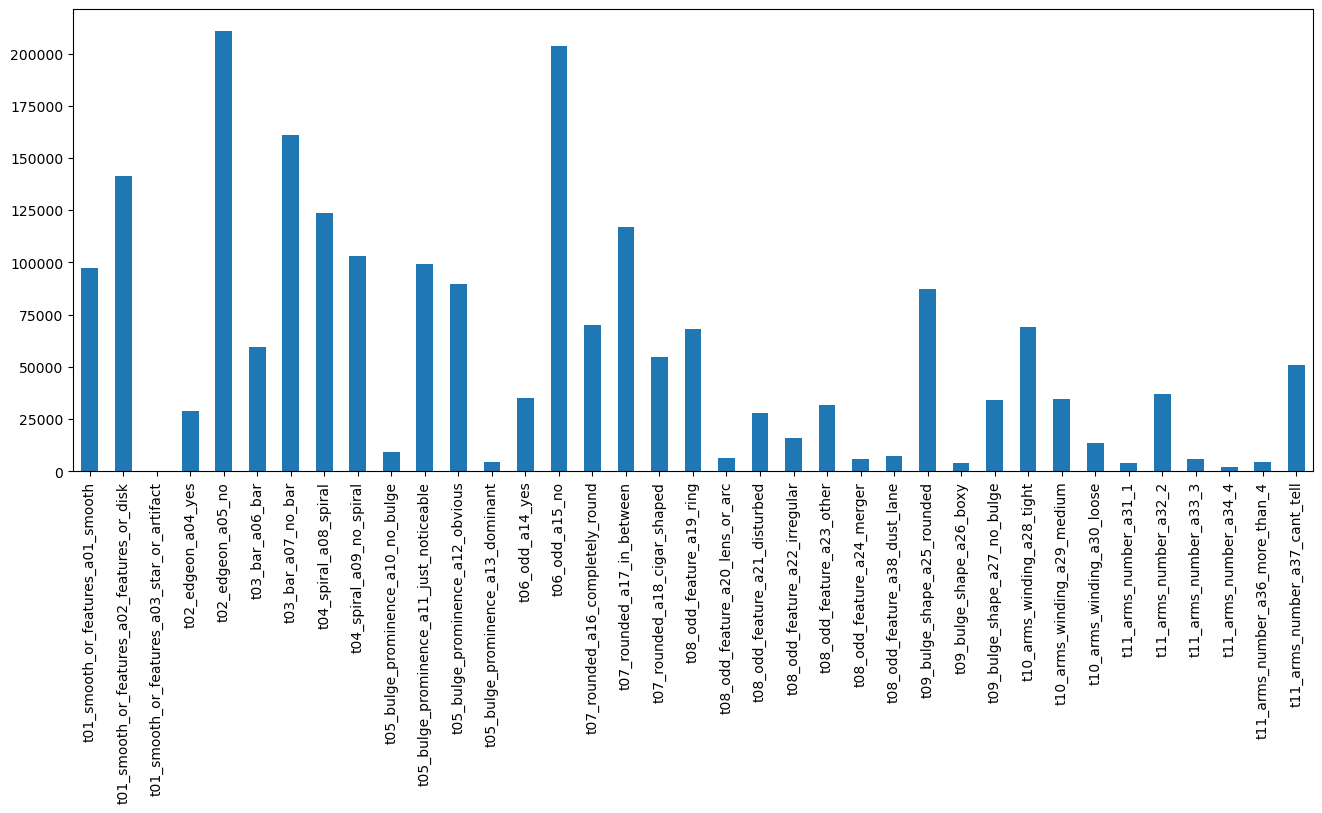

In [44]:
# Distribution of Features where value > 0.5
labels = [text.replace("_debiased", "") for text in hart_keep[4:]]
feature_distribution = (df_joined_clean[hart_keep[4:]] > 0.5).sum()
display(feature_distribution)
ax = feature_distribution.plot.bar(figsize=(16, 6))
ax.set_xticklabels(labels)
plt.show()

# Clean Images
Process for cleaning images:
- Skip if image in `not_in_table` list
- Find main central feature of image
- Crop to feature
- Convert to gray-scale
- Scale down to 106×106 (¼ original size of 424×424)
- Save to new folder with same name

# Images to test
- 5 = small
- 184 = blue background
- 271 = fills image space
- 287 = line through center
- 685/686 = two galaxies
- 941 = orange background
- 234499 = vertical

In [45]:
# Since all images are the same size:
MIN_CONTOUR_AREA = 100  # picked by testing
IMAGE_CENTER = (212, 212)
RECT_106_START = IMAGE_CENTER[0] - 106//2
RECT_212_START = IMAGE_CENTER[0] - 212//2
RECT_106_END = RECT_106_START + 106
RECT_212_END = RECT_212_START + 212
TARGET_SIZE = (106, 106)

def process_image(image_name: str, save_dir: str = None, visualize: bool = False):
    """Process a jpg image of a galaxy for neural network training and testing.

    Steps:
    1. Read image with OpenCV from JPG
    2. Convert to grayscale
    3. Gaussian Blur
    4. Threshold
    5. Dilate threshold
    6. Find Contour with a minimum area with center closest to center of image
    7. Get bounding box of contour
    8. Check if bounding box fully contained inside target rectangles
    9. Crop/Scale
        - If inside smallest rectangle crop only
        - If inside second rectangle crop, then scale
        - Otherwise, scale
    10. Save to given directory, if desired as PNG
    11. Visualize process, if desired

    :param image_name: Name of image (WITHOUT .jpg extension) ex: 34 NOT 34.jpg
    :param save_dir: save the image as a PNG with the same name to the directory, defaults to None
    :param visualize: Visually show process, defaults to False
    """
    image_orig = cv2.imread(f"{ORIGINAL_IMAGES_DIR}{image_name}.jpg")

    # Convert the image to grayscale
    gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to smooth a bit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Threshold to make lines clear
    ret, thresh = cv2.threshold(blurred, 30, 255, 0)  # 30 picked by testing

    # Perform dilation on the threshold image to remove some holes & add small padding
    element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5, 5))
    dilated = cv2.dilate(thresh, element, iterations=1)

    # --- Find contours ---
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If our images were not all the same:
    # Find the center of the image
    # image_center = np.asarray(image.shape) / 2
    # image_center = (int(image_center[1]), int(image_center[0])) # note the order: (x,y)

    contour_info = []
    acceptable_contours = []
    for contour in contours:
        # Calculate the area of the contour
        contour_area = cv2.contourArea(contour)
        # If the contour area is less than the minimum contour area, ignore it
        if contour_area < MIN_CONTOUR_AREA:
            continue

        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            contour_center = (cX, cY)
        else:
            continue
        dist_to_center = distance.euclidean(IMAGE_CENTER, contour_center)
        contour_info.append((contour, dist_to_center))
        if visualize:
            acceptable_contours.append(contour)

    closest_contour = min(contour_info, key = lambda x: x[1])[0]

    if visualize:
        img_contour = image_orig.copy()
        # Draw all contours
        cv2.drawContours(img_contour, acceptable_contours, -1, (0,255,0), 1) # green color
        # Draw the contour closest to the center
        cv2.drawContours(img_contour, [closest_contour], -1, (0, 0, 255), 2) # red color

    # --- Bounding Rectangle of closest contour ---
    br_x, br_y, br_w, br_h = cv2.boundingRect(closest_contour)
    if visualize:
        img_bounding_rect = image_orig.copy()
        cv2.drawContours(img_bounding_rect, [closest_contour], -1, (0, 0, 255), 2) # red color
        cv2.rectangle(img_bounding_rect, (br_x, br_y), (br_x + br_w, br_y + br_h), (0, 0, 255), 2)  #red rectangle

    # --- Target Rectangles ---
    # add rect start and end here if images were not all the same
    if visualize:
        img_targets = image_orig.copy()
        cv2.rectangle(img_targets, (br_x, br_y), (br_x + br_w, br_y + br_h), (0, 0, 255), 2)  # red rectangle
        cv2.rectangle(img_targets, (RECT_106_START, RECT_106_START), (RECT_106_END, RECT_106_END), (0, 255, 0), 2)  # green rectangle
        cv2.rectangle(img_targets, (RECT_212_START, RECT_212_START), (RECT_212_END, RECT_212_END), (0, 255, 255), 2)  # yellow rectangle

    # --- Crop/Scale Checking ---
    in_106_rect = False
    in_212_rect = False
    if br_x >= RECT_106_START and br_y >= RECT_106_START and br_x + br_w <= RECT_106_END and br_y + br_h <= RECT_106_END:
        in_106_rect = True
    elif br_x >= RECT_212_START and br_y >= RECT_212_START and br_x + br_w <= RECT_212_END and br_y + br_h <= RECT_212_END:
        in_212_rect = True

    # Crop/Scale as needed
    if in_106_rect:
        # already correct size, just crop
        final_image = gray[RECT_106_START:RECT_106_END, RECT_106_START:RECT_106_END]  # [y1:y2, x1,x2]
    elif in_212_rect:
        # crop then scale
        cropped_image = gray[RECT_212_START:RECT_212_END, RECT_212_START:RECT_212_END]  # [y1:y2, x1,x2]
        final_image = cv2.resize(cropped_image, TARGET_SIZE)
    else:
        # no cropping just scale to final size
        final_image = cv2.resize(gray, TARGET_SIZE)

    # Save the image as PNG (don't want any more compression)
    if save_dir is not None:
        cv2.imwrite(f"{save_dir}{image_name}.png", final_image)

    # Create a matplotlib plot of 6 images showing the steps in the process
    # Just for example and testing purposes
    # Don't use this when looping through the images 
    if visualize:
        print("In 106:", in_106_rect, "In 212", in_212_rect)
        plt.figure()
        f, ax = plt.subplots(2, 4, figsize=(13, 6.2))
        ax[0][0].imshow(cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB))
        ax[0][1].imshow(blurred, cmap='gray', vmin=0, vmax=255)
        ax[0][2].imshow(thresh, cmap='gray', vmin=0, vmax=255)
        ax[0][3].imshow(dilated, cmap='gray', vmin=0, vmax=255)
        ax[1][0].imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
        ax[1][1].imshow(cv2.cvtColor(img_bounding_rect, cv2.COLOR_BGR2RGB))
        ax[1][2].imshow(cv2.cvtColor(img_targets, cv2.COLOR_BGR2RGB))
        ax[1][3].imshow(final_image, cmap='gray', vmin=0, vmax=255)

        # Plot titles
        ax[0][0].set_title("Original")
        ax[0][1].set_title("Gaussian Blur")
        ax[0][2].set_title("Threshold")
        ax[0][3].set_title("Dilate")
        ax[1][0].set_title("Contour")
        ax[1][1].set_title("Bounding Box")
        ax[1][2].set_title("Crop/Scale Targets")
        ax[1][3].set_title("Final Image")
        plt.show()

In 106: False In 212 True


<Figure size 640x480 with 0 Axes>

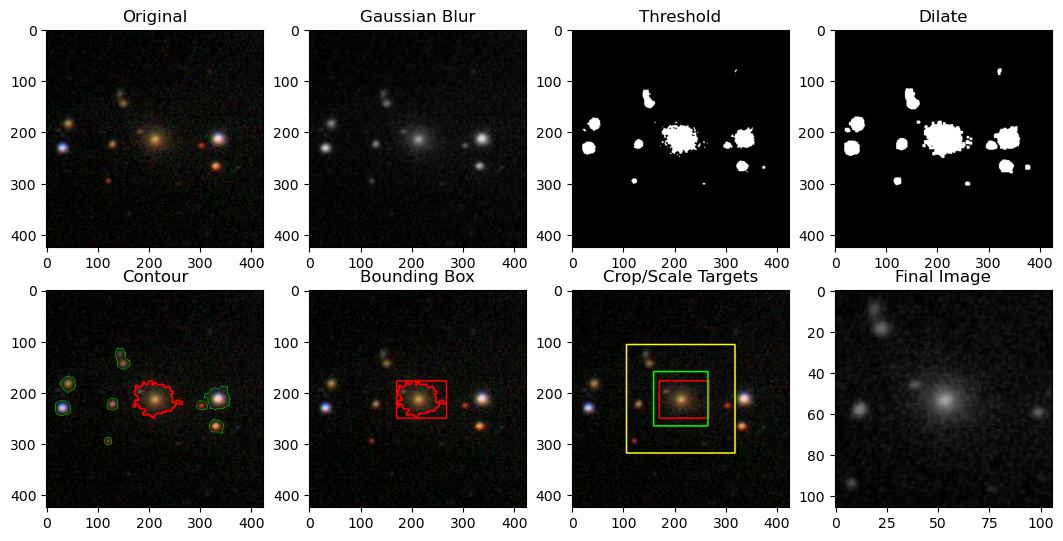

In [46]:
# process_image("2008", save_dir=None, visualize=True)
process_image("5", save_dir=None, visualize=True)
# process_image("234499", save_dir=None, visualize=True)

## Process all image files into smaller, gray scale PNG files for the model

In [48]:
# Exit if files already exist to prevent accidental running
if len(glob.glob(PROCESSED_IMAGES_DIR + "*.png")) >= 1\
    or len(glob.glob(TRAIN_IMAGES_DIR + "*.png")) >= 1\
    or len(glob.glob(TEST_IMAGES_DIR + "*.png")) >= 1:
    print("Processed images already exist, delete if you want to remake them")
    raise KeyboardInterrupt

# Keep track of how long this will take
start_process_time = time.time()

current_image = 0
for image in image_names:
    if image in not_in_table:
        # these images do not need to be processed as they are not in our data table
        continue
    try:
        # process the image and save as a PNG file
        process_image(image, save_dir=PROCESSED_IMAGES_DIR, visualize=False)
    except Exception as e:
        print(f"❌ Image `{image}` failed to process (current_image int= `{current_image}`)")
        traceback.print_exc()
        break
    current_image += 1
    if current_image % 10_000 == 0:
        print(f"  Processed {current_image:,} image files")
        
print("Processing complete")

_hr, _remainder = divmod(time.time() - start_process_time, 3600)
_min, _sec = divmod(_remainder, 60)
print(f"--- Time Taken: {int(_hr):02d}:{int(_min):02d}:{int(_sec):02d} ---")

  Processed 10,000 image files
  Processed 20,000 image files
  Processed 30,000 image files
  Processed 40,000 image files
  Processed 50,000 image files
  Processed 60,000 image files
  Processed 70,000 image files
  Processed 80,000 image files
  Processed 90,000 image files
  Processed 100,000 image files
  Processed 110,000 image files
  Processed 120,000 image files
  Processed 130,000 image files
  Processed 140,000 image files
  Processed 150,000 image files
  Processed 160,000 image files
  Processed 170,000 image files
  Processed 180,000 image files
  Processed 190,000 image files
  Processed 200,000 image files
  Processed 210,000 image files
  Processed 220,000 image files
  Processed 230,000 image files
Processing complete
--- Time Taken: 00:11:58 ---


- Time = **00:37:04** for 239,573 files (1st run)
- Time = **00:11:58** for 239,267 files (2nd run)

No errors were encountered in processing.

Total folder size ~1.33 GB (less than half of original JPG images)

In [49]:
# Check Processed Images
processed_image_files = glob.glob(PROCESSED_IMAGES_DIR + "*.png")
print("Processed Image count:", len(processed_image_files))

Processed Image count: 239267


## Split images for Training and Testing

- `RANDOM_STATE` must be the same in this notebook and `model_training` notebook otherwise `test_train_split()` will fail
- If `class_reduced` column is changed this must be rerun
- Just **cut** and **paste** images back into `PROCESSED_IMAGES_DIR` folder to save time

In [50]:
# Only run if images in Processed Directory and NOT in Train Directory
if not (len(glob.glob(PROCESSED_IMAGES_DIR + "*.png")) >= 1
        and len(glob.glob(TRAIN_IMAGES_DIR + "*.png")) == 0
        and len(glob.glob(TEST_IMAGES_DIR + "*.png")) == 0):
    print("Images missing from processed directory or images in training/testing directory")
    raise KeyboardInterrupt

# Split the images up between testing and training
stratify_data = df_joined_clean["class_reduced"].values
x_image_id_names = df_joined_clean["asset_id"]
_junk_y = np.zeros((x_image_id_names.shape[0], 2), dtype=np.int8)
print("asset_id column is sorted:", x_image_id_names.is_monotonic_increasing)

X_train_assets, X_test_assets, _yj_train, _yj_test = train_test_split(x_image_id_names,
                                                                      _junk_y,
                                                                      random_state=RANDOM_STATE,
                                                                      stratify=stratify_data)

# Move files depending on what group they have been split into
for image_name in X_train_assets:
    Path(f"{PROCESSED_IMAGES_DIR}{image_name}.png").rename(f"{TRAIN_IMAGES_DIR}{image_name}.png")
print("Training images moved")
for image_name in X_test_assets:
    Path(f"{PROCESSED_IMAGES_DIR}{image_name}.png").rename(f"{TEST_IMAGES_DIR}{image_name}.png")
print("Testing images moved")

asset_id column is sorted: True
Training images moved
Testing images moved
